# Construct Embeddings Store from D2 Docs

In [15]:
from os import getenv
from dotenv import load_dotenv
from langchain.document_loaders import GithubFileLoader

load_dotenv()

loader = GithubFileLoader(
    repo="terrastruct/d2-docs",
    access_token=getenv("GITHUB_ACCESS_TOKEN"),
    github_api_url="https://api.github.com",
    file_filter=lambda file_path: file_path.endswith(
        ".md"
    ) and "tour" in file_path,
    branch="master",
)

In [16]:
d2_docs = loader.load();

In [17]:

from langchain.text_splitter import  RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings


text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(d2_docs)


embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
db = FAISS.from_documents(splits, embeddings)


In [18]:
db.save_local("d2-tour-embeddings-05-05-2024")

# Usage

Now we've got embeddings for the docs. Let's see how we can use them to create

err: failed to compile input.d2: /Users/merrickchristensen/Developer/d2-ai/input.d2:18:23: unknown shape "factory"
err: /Users/merrickchristensen/Developer/d2-ai/input.d2:32:24: unknown shape "process"
err: /Users/merrickchristensen/Developer/d2-ai/input.d2:35:25: unknown shape "process"
err: /Users/merrickchristensen/Developer/d2-ai/input.d2:68:25: unknown shape "factory"


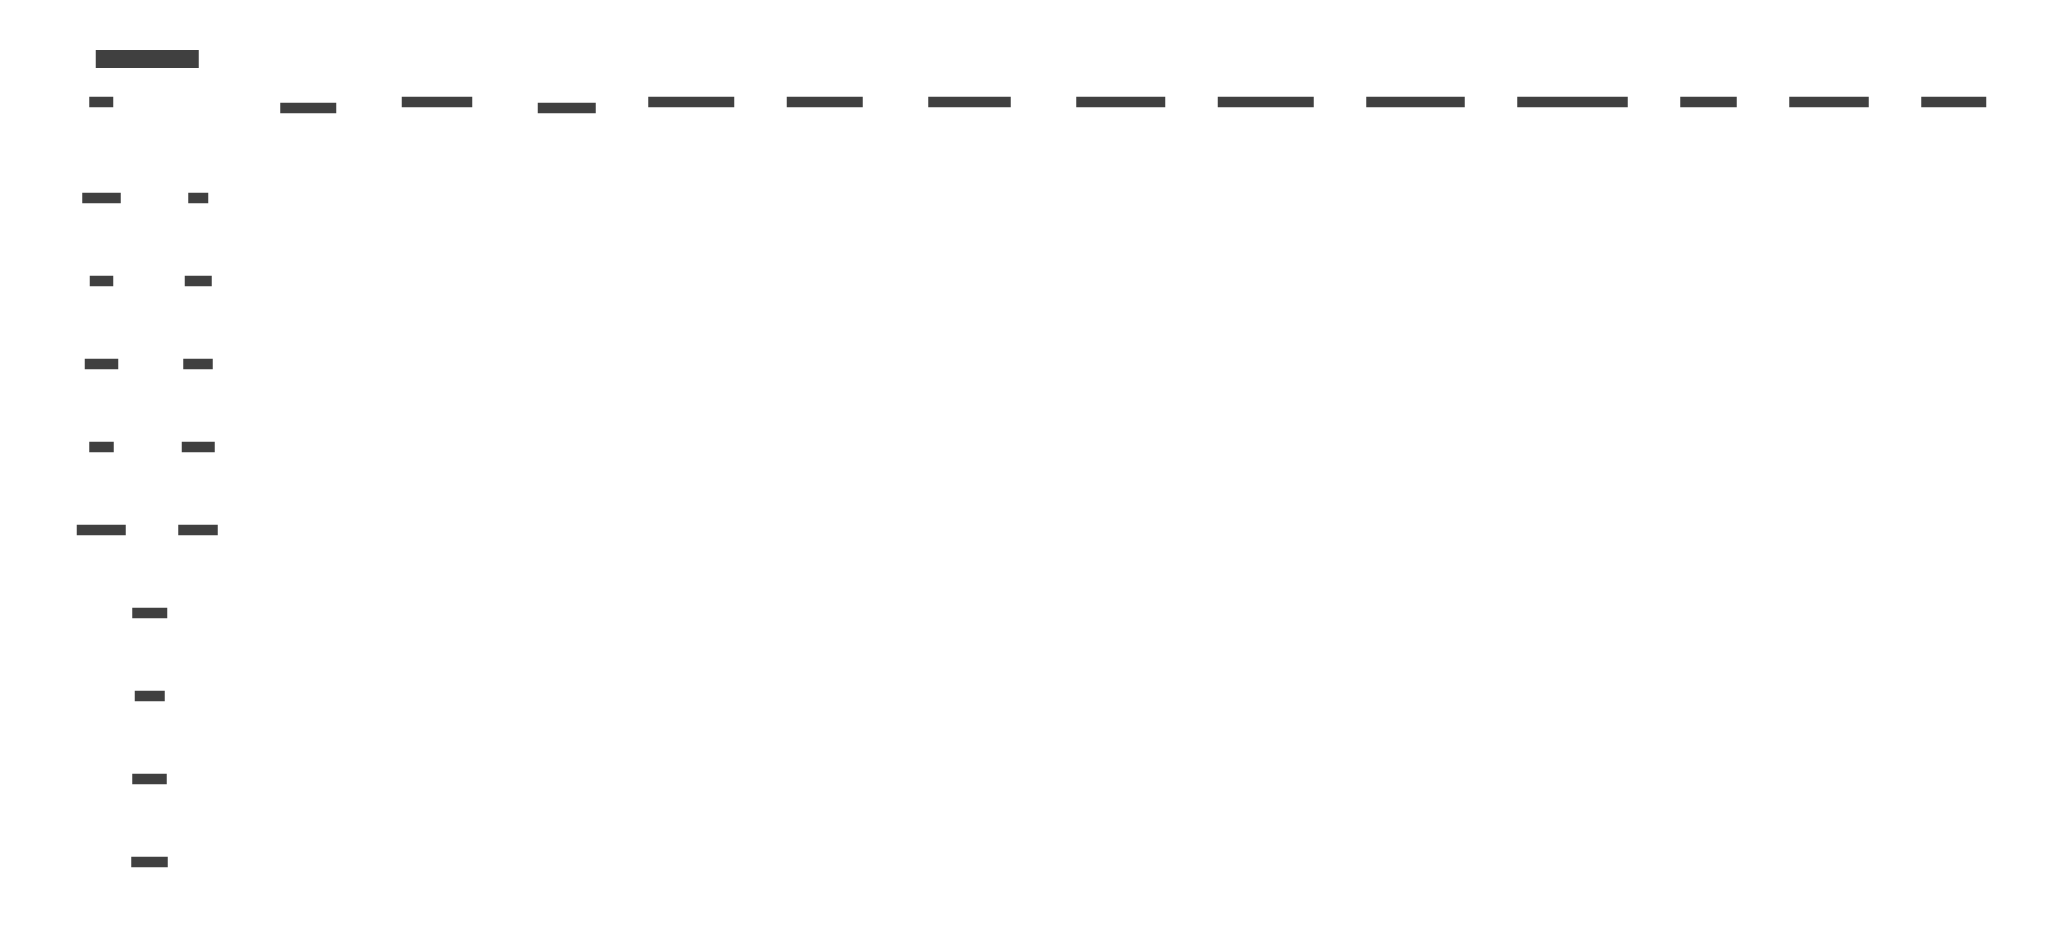

In [9]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_core.prompts import PromptTemplate
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough
import shutil
import re

def to_dash_case(s):
    s = re.sub(r'\W+', '-', s)
    s = re.sub(r'-+', '-', s)
    s = s.strip('-')
    return s.lower()


store = FAISS.load_local(folder_path="d2-tour-embeddings-05-05-2024", embeddings=OpenAIEmbeddings(model="text-embedding-3-large"), allow_dangerous_deserialization=True)
retriever = store.as_retriever();

with open('./d2.txt', 'r') as file:
    universal_prompt = file.read()

prompt = PromptTemplate(template='''
You are an expert d2 programmer. You answer questions with lots of examples. Never explain yourself. Only produce d2 code. Don't wrap it in a ```d2 code block. Do not use icons. Do not use shapes that aren't listed here.

Use this context about d2 lang: {context} 
To answer the following question: {prompt}
''', input_variables=["context", "prompt"])
model = ChatOpenAI(model="gpt-4-turbo")

def format_docs(docs):
    "\n\n".join([doc.page_content for doc in docs])

diagram = "how a pencil is made in detail including the geographic locations that provide the various materials"

prompt_with_context = ({
    "context" : retriever | format_docs, "prompt": RunnablePassthrough()
    }
    | prompt
).invoke("Generate a D2 chart that explains " + diagram).to_string()



final_prompt = universal_prompt + prompt_with_context

result = model.invoke(final_prompt) 

with open('./input.d2', 'w') as file:
    file.write(result.content)

import subprocess
from IPython.display import SVG

command = "d2 input.d2 output.svg"
subprocess.run(command, text=True, shell=True)
shutil.copy('output.svg', 'svgs/'+to_dash_case(diagram)+'.svg')
display(SVG(filename='output.svg'))